In [357]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

In [358]:
data_path='data/Test-FundPrice.csv'
trade_plan_path='data/Test-BuySellTrade.xlsx'

commission_sheet='Commision'

report_path=f'report/Test_BuySell_MyETFFunds.xlsx'
trade_sheet='BuySell'

# trade_sheet='BuySell_Swing'
# report_path=f'report/Test_BuySell_SwingTrade_MyETFFunds.xlsx'

# Read Price CSV

In [359]:
df=pd.read_csv(data_path,parse_dates=['Date/Time'],dayfirst=True)
df.columns=['symbol','date','price']
df.info()
print(df.sample(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   symbol  395 non-null    object        
 1   date    395 non-null    datetime64[ns]
 2   price   395 non-null    float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 9.4+ KB
    symbol       date   price
169   ACWI 2022-11-16   86.98
122   BITW 2023-01-04    6.14
187   ACWI 2022-12-13   88.25
94    BITW 2022-11-22    7.09
271    QQQ 2022-12-20  269.54
129   BITW 2023-01-13    8.25
293    QQQ 2023-01-24  288.37
188   ACWI 2022-12-14   87.91
50    AAXJ 2023-01-13   70.75
213   ACWI 2023-01-23   90.46


# List Symbol and Plot Chart

['AAXJ', 'BITW', 'ACWI', 'QQQ', 'SPY']
==============AAXJ==============


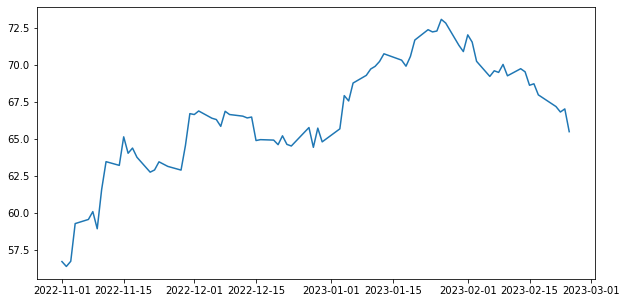

==============BITW==============


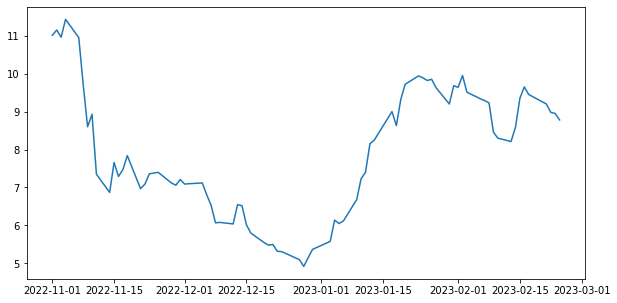

==============ACWI==============


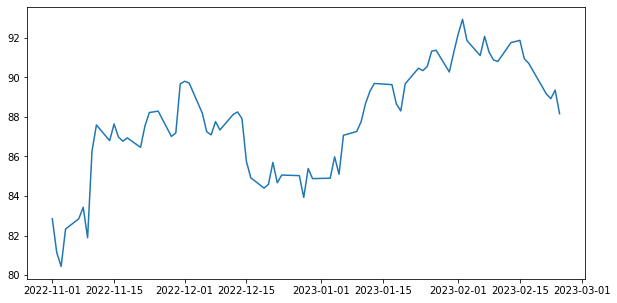

==============QQQ==============


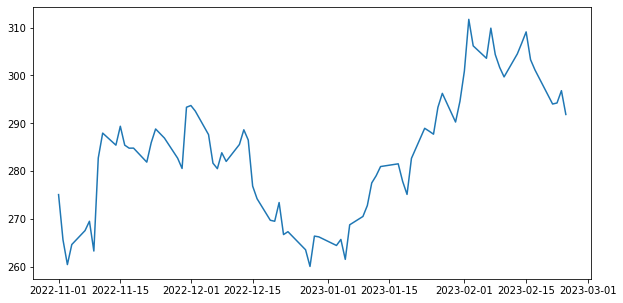

==============SPY==============


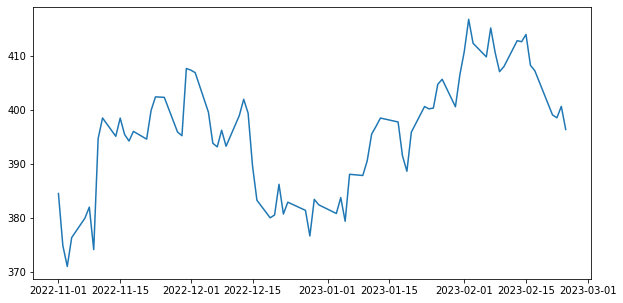

In [360]:
list_symbols=list(df['symbol'].unique())
# list_symbols=['ACWI']


print(list_symbols)
for  symbol in list_symbols:
    print(f"=============={symbol}==============")
    dfFund=df.query('symbol==@symbol')
    plt.figure(figsize=(10, 5))
    plt.plot(dfFund['date'],dfFund['price'])
    plt.show()

# Get Trade Data and Commission

In [361]:
# read commnision 
dfAssetInfo=pd.read_excel(trade_plan_path,engine="openpyxl",sheet_name='Commision',\
                    index_col='symbol', dtype ={'buy_comm_pct': np.float64,'sell_comm_pct': np.float64})

# check where  funds 's commision  in portfolio  are avaible?
dfNoComissionInfo= [ item for item in list_symbols if item not in list(dfAssetInfo.index)]
if  len(dfNoComissionInfo)>0:
  raise Exception(f"{dfNoComissionInfo} didn't found commision info in {asset_comm_path}")
else:
  dfAssetInfo=dfAssetInfo.loc[list(list_symbols),:]
  print("Commmision info")
  print(dfAssetInfo) 

# For instance   AAXJ Price=100 but we need to pay 101 $

NameError: name 'asset_comm_path' is not defined

In [ ]:
dfPlan=pd.read_excel(trade_plan_path,engine="openpyxl",sheet_name=trade_sheet, \
                     parse_dates=['trade_date'],dtype ={'portion_pct': np.float64})

#total buy portion is equal or greater than sell portion
buy_sum_act=dfPlan.query("action=='b'").portion_pct.sum()
sell_sum_act=dfPlan.query("action=='s'").portion_pct.sum()

all_portion=0

In [ ]:
if buy_sum_act<sell_sum_act:
  raise Exception("Not allow Buy <= Sell")   
else:
    if buy_sum_act>sell_sum_act:
       print("=============Calculate the last portion to be sellable")
       sellAllAtNow=buy_sum_act-sell_sum_act 
       dfLastPrice=pd.DataFrame(columns=list(dfPlan.columns), data=[ [df['date'].max(),sellAllAtNow,'s']])
       print(dfLastPrice)
       dfPlan=pd.concat([dfPlan,dfLastPrice])
       dfPlan=dfPlan.reset_index(drop=True)

    tradeDateList= [ d for d in list(dfPlan['trade_date']) ]    
    all_portion=buy_sum_act   
    print(f"portion = {all_portion} on")
    
print("==========================Summarize All Trade==========================================")
print(f"No Buy/Sell {dfPlan.groupby(['action']).size()}")
print(dfPlan)

In [ ]:
# To make it easier for use to understand portfolio transatoin 
TotalBudget=150*1000
rrr=TotalBudget % all_portion
if rrr !=0 :
  raise Exception(f"Your Budget {TotalBudget} is  not proportional  Portion with {all_portion}")
else:
  print(f"Your Budget {TotalBudget} is  proportional  Portion with {all_portion}")

# Custom Function

In [ ]:
# figure out the amount of qty from total fund total value
def get_qty_buy(item):
    xCost=(item['portion_pct']/all_portion)*TotalBudget  
    xPrice=item['price_on_comm']
    qty=xCost/xPrice
    return qty

# figure the amount of  qty out  from total qty
def get_qty_sell(item,TotalQty):  
    qty=(item['portion_pct']/all_portion)*TotalQty
    return qty

In [ ]:
def set_commision_by_action(item):
  x=item['symbol']  
  if item['action']=='b':
    comm_type='buy_comm_pct'
  elif  item['action']=='s':
    comm_type='sell_comm_pct'
  try:
     return dfAssetInfo.loc[x,comm_type]
  except Exception as ex:
     print(f"Error : no {x} to get commission")
     return 0

In [362]:
dict_dfTran={}
dfSummary=pd.DataFrame(columns=['Symbol','BuyValue','AvgBuyPrice','SellValue','AvgSellPrice','PL','Percent_PL'])

dfSummary

,Symbol,BuyValue,AvgBuyPrice,SellValue,AvgSellPrice,PL,Percent_PL


In [363]:
#https://www.w3resource.com/pandas/dataframe/dataframe-apply.php

for symbol in list_symbols:
    print(f"*******************{symbol}*******************")

    dfBS=df[ (df['symbol']==symbol) & (df['date'].isin(tradeDateList))]
    # if len(tradeDateList)==len(dfBS):
        
     # Step1  join price data (filter by sybom and the date whiich you have buy/sell action)   
    dfBS=dfBS.merge(dfPlan,how='inner',left_on='date',right_on='trade_date')
     # remove  redundant data  
    dfBS=dfBS.drop(columns=['trade_date'])     
       
    
     # Step2 calculate commision function
    dfBS['comm']=dfBS.apply(set_commision_by_action,axis=1) # 2.1
    
     # The price that allows you to buy the fund is more expensive than the actual asset price  1%  ,other the other had 
     # Buy price*1.0x=??   
    dfBS['price_on_comm']=dfBS.apply(lambda item : item['price']*(1+ (item['comm']/100)) if item['action']=='b' else item['price']*(1-(item['comm']/100)), axis=1)
    dfBS['price_on_comm']=dfBS['price_on_comm'].round(2) #2.2   
    # print(dfBS)
        
     # Step3  To make it easier to calculate and trading sumary in tearm of qty both buy/sell , both use different way
     # we recommend spliting this dataframe  into 2 dataframe
     #  BuyDataFrame and Sell Date , and we will merge both later  
    
    #3.1 query only buy action
    print("======================Buy=======================")
    buyDF=dfBS.query("action=='b'")   
    
    # 3.2 send the  row to function to calculate qty 
    buyDF['qty']=buyDF.apply(get_qty_buy,axis=1) 
    buyDF['value']=round(buyDF['qty']*buyDF['price_on_comm'],0)
    
    
    # 1 is buy (I will take columne to apply cumsum function to calcaulate cumulative return
    buyDF['action_value']=buyDF['value']
    buyDF['action_qty']=buyDF['qty']
    
    # 3.3 Total qty and value and avg
    TotalQty=buyDF['qty'].sum()
    TotalValue=round(buyDF['value'].sum(),0)
    AvgPrice=round(TotalValue/TotalQty,2)
    
    print(buyDF[['date','portion_pct','value' ,'price','comm','price_on_comm','qty']])
    print(f"Total Buy {symbol} : qty={TotalQty} and value={TotalValue} at AvgPrice={AvgPrice}")
    
    # Step4 follow every step corresponidng to prev step#3
    print("=======================Sell=======================")
    # step#4.1
    sellDF=dfBS.query("action=='s'")  
    
    # ste#4.2
    sellDF['qty']=sellDF.apply(get_qty_sell,axis=1,args=(TotalQty,))
    sellDF['value']=round(sellDF['qty']*sellDF['price_on_comm'],0)
    
    # -1 is sell (I will take columne to apply cumsum function to calcaulate cumulative return
    sellDF['action_value']=sellDF['value']*-1
    sellDF['action_qty']=sellDF['qty']*-1
    
    print(sellDF[['date' ,'portion_pct','value','price','comm','price_on_comm','qty']])
    print(f"Total Sell {symbol} : qty={SellTotalQty} and value={SellTotalValue} at AvgPrice={SellAvgPrice}")

    
    print("======================Merge Buy & Sell======================")
    # step 5  concatenate buy and sell dataframe 
    dfTran=pd.concat([buyDF,sellDF],axis=0)
    dfTran=dfTran.sort_values(by=['date'])
    dfTran[['value','action_value']]=dfTran[['value','action_value']].round(0)

    # step 6 accumulate value and qury over entire data since start buying to last record 
    dfTran['net_value']=dfTran['action_value'].cumsum(axis = 0) 
    dfTran['net_qty']=dfTran['action_qty'].cumsum(axis = 0)  
    dfTran['avg_price']=round( dfTran['net_value']/dfTran['net_qty'],2)
    
    dfTran=dfTran.sort_values(by=['date'])
    print(dfTran[['date' ,'action','price_on_comm','qty','net_qty','value','net_value','avg_price']])
    
    dict_dfTran[symbol]=dfTran
    
    print("=======================Summarize Gain/Loss=======================")
    #step 7 create total buy/sell value , avg prie and profit/loss(value and %) of  all funds 
    # step 7.1 apply sum agg over  value and qty to find avg throughout  the whold dataframe
    SellTotalQty=sellDF['qty'].sum()
    SellTotalValue=round(sellDF['value'].sum(),0)
    SellAvgPrice=round(SellTotalValue/SellTotalQty,0)
    

    
    # step #7.2
    PL=round(SellTotalValue-TotalValue,0)
    PCT_PL=round(PL/TotalValue*100,2)
    
    # step# 7.3 
    # you take amont 100000.0 and gain profit103500 from investment on this etf fund 
    summary_data={'Symbol':symbol,'BuyValue':TotalValue,'AvgBuyPrice':AvgPrice,'SellValue':SellTotalValue,\
                  'AvgSellPrice':SellAvgPrice, 'PL':PL,'Percent_PL':PCT_PL
                 }
    dfSummary=dfSummary.append(summary_data,ignore_index=True)
    
    print(dfSummary)

    


*******************AAXJ*******************
======================Buy=======================
        date  portion_pct    value  price  comm  price_on_comm         qty
0 2022-11-04         50.0  50000.0  59.26   0.0          59.26  843.739453
1 2022-11-09         25.0  25000.0  58.91   0.0          58.91  424.376167
2 2022-11-10         25.0  25000.0  61.56   0.0          61.56  406.107862
4 2023-01-04         50.0  50000.0  67.92   0.0          67.92  736.160188
Total Buy AAXJ : qty=2410.383670996515 and value=150000.0 at AvgPrice=62.23
=======================Sell=======================
        date  portion_pct    value  price  comm  price_on_comm         qty
3 2022-12-15         50.0  52129.0  64.88   0.0          64.88  803.461224
5 2023-02-03         25.0  28218.0  70.24   0.0          70.24  401.730612
6 2023-02-10         25.0  27824.0  69.26   0.0          69.26  401.730612
7 2023-02-21         50.0  53977.0  67.18   0.0          67.18  803.461224
Total Sell AAXJ : qty=389.41338

C:\Users\pongthsa\AppData\Local\Temp\ipykernel_25376\1813232302.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  buyDF['qty']=buyDF.apply(get_qty_buy,axis=1)
C:\Users\pongthsa\AppData\Local\Temp\ipykernel_25376\1813232302.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  buyDF['value']=round(buyDF['qty']*buyDF['price_on_comm'],0)
C:\Users\pongthsa\AppData\Local\Temp\ipykernel_25376\1813232302.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

        date action  price_on_comm         qty       net_qty    value  \
0 2022-11-04      b          82.33  607.312037  6.073120e+02  50000.0   
1 2022-11-09      b          81.89  305.287581  9.125996e+02  25000.0   
2 2022-11-10      b          86.28  289.754288  1.202354e+03  25000.0   
3 2022-12-15      s          85.75  594.628165  6.077257e+02  50989.0   
4 2023-01-04      b          85.98  581.530589  1.189256e+03  50000.0   
5 2023-02-03      s          91.86  297.314082  8.919422e+02  27311.0   
6 2023-02-10      s          90.80  297.314082  5.946282e+02  26996.0   
7 2023-02-21      s          89.16  594.628165  2.273737e-13  53017.0   

   net_value     avg_price  
0    50000.0  8.233000e+01  
1    75000.0  8.218000e+01  
2   100000.0  8.317000e+01  
3    49011.0  8.065000e+01  
4    99011.0  8.325000e+01  
5    71700.0  8.039000e+01  
6    44704.0  7.518000e+01  
7    -8313.0 -3.656096e+16  
=======================Summarize Gain/Loss=======================
  Symbol  BuyVa

In [369]:
dfSummary

,Symbol,BuyValue,AvgBuyPrice,SellValue,AvgSellPrice,PL,Percent_PL
3,QQQ,150000.0,267.66,163243.0,291.0,13243.0,8.83
0,AAXJ,150000.0,62.23,162148.0,67.0,12148.0,8.10
2,ACWI,150000.0,84.09,158313.0,89.0,8313.0,5.54
4,SPY,150000.0,381.38,157181.0,400.0,7181.0,4.79
1,BITW,150000.0,8.31,143675.0,8.0,-6325.0,-4.22


In [386]:
dfPort=dfSummary[['BuyValue','SellValue','PL']].sum().to_frame('All Funds')
dfPort=dfPort.T
dfPort['PercentPL']=round( (dfPort['PL']/dfPort['BuyValue'] *100) ,0)
dfPort

,BuyValue,SellValue,PL,PercentPL
All Funds,750000.0,784560.0,34560.0,5.0


In [387]:
writer=pd.ExcelWriter(report_path,engine='xlsxwriter') 

dfPort.to_excel(writer,sheet_name='TotalPort',index=False)

dfSummary=dfSummary.sort_values(by=['Percent_PL'],ascending=False)
dfSummary.to_excel(writer, sheet_name="Summary",index=False)

for symbol,tranDF in dict_dfTran.items():
 tranDF=tranDF.drop(columns=['symbol'])   
 tranDF.to_excel(writer, sheet_name=symbol,index=False) 
writer.save()

writer.close()

print("Successfully")

C:\Users\pongthsa\AppData\Local\Temp\ipykernel_25376\886247830.py:11: FutureWarning: save is not part of the public API, usage can give in unexpected results and will be removed in a future version
  writer.save()


Successfully


D:\ProgramData\Anaconda3\envs\myquant_exp\lib\site-packages\xlsxwriter\workbook.py:339: UserWarning: Calling close() on already closed file.
  warn("Calling close() on already closed file.")
